<a href="https://colab.research.google.com/github/alifabdullah/DataScience/blob/main/BUSI_project_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os, sys, time, shutil, random
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch, torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import timm


### --- CONFIG ---

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sabahesaraki/breast-ultrasound-images-dataset")

print("Path to dataset files:", path)


100%|██████████| 195M/195M [00:03<00:00, 62.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sabahesaraki/breast-ultrasound-images-dataset/versions/1


In [7]:
BASE_PATH = '/root/.cache/kagglehub/datasets/sabahesaraki/breast-ultrasound-images-dataset/versions/1/Dataset_BUSI_with_GT'
tumor_types = []
for path in os.listdir(BASE_PATH):
    # Assuming each directory in BASE_PATH is a tumor type
    tumor_types.append(path)
print(tumor_types)

['normal', 'benign', 'malignant']


In [8]:
OUT_DIR = "./outputs"
IMG_SIZE = 224
BATCH = 32
EPOCHS = 8
LR = 1e-4
SEED = 42

os.makedirs(OUT_DIR, exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)


#### --- Gather dataset ---

In [9]:
imgs, labels = [], []
for idx, tumor in enumerate(tumor_types):
    folder = Path(BASE_PATH) / tumor
    for f in folder.glob("*.png"):
        if "mask" in f.name.lower():  # skip segmentation masks
            continue
        imgs.append(str(f)); labels.append(idx)

print(f"Found {len(imgs)} images")

Found 780 images


#### --- Dataset class ---

In [10]:
class ImgDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths; self.labels = labels; self.transform = transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert('RGB')
        if self.transform: img = self.transform(img)
        return img, self.labels[idx]

transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

#### Train/Val/Test split

In [11]:
X_tr, X_tmp, y_tr, y_tmp = train_test_split(imgs, labels, test_size=0.3, stratify=labels, random_state=SEED)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, stratify=y_tmp, random_state=SEED)

train_loader = DataLoader(ImgDataset(X_tr,y_tr,transform), batch_size=BATCH, shuffle=True)
val_loader   = DataLoader(ImgDataset(X_val,y_val,transform), batch_size=BATCH, shuffle=False)
test_loader  = DataLoader(ImgDataset(X_test,y_test,transform), batch_size=BATCH, shuffle=False)

print("Train/Val/Test:", len(X_tr), len(X_val), len(X_test))

Train/Val/Test: 546 117 117


#### --- Model ---

In [12]:
NUM_CLASSES = len(tumor_types)
def make_model():
    try:
        m = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=NUM_CLASSES)
        print("Using ViT from timm")
    except:
        print("Fallback: Simple CNN")
        class SimpleCNN(nn.Module):
            def __init__(self):
                super().__init__()
                self.feats = nn.Sequential(
                    nn.Conv2d(3,32,3,padding=1),
                    nn.ReLU(),
                    nn.MaxPool2d(2),
                    nn.Conv2d(32,64,3,padding=1),
                    nn.ReLU(),
                    nn.MaxPool2d(2),
                    nn.Conv2d(64,128,3,padding=1),
                    nn.ReLU(),
                    nn.AdaptiveAvgPool2d(1)
                )
                self.fc = nn.Linear(128, NUM_CLASSES)
            def forward(self,x):
                x=self.feats(x); return self.fc(x.view(x.size(0),-1))
        m = SimpleCNN()
    return m.to(device)

model = make_model()
opt = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Using ViT from timm


#### --- Training ---

In [13]:
def train_epoch():
    model.train(); losses=[]; correct=0; total=0
    for x,y in train_loader:
        x,y = x.to(device), torch.tensor(y).to(device)
        opt.zero_grad()
        out = model(x); loss = criterion(out,y)
        loss.backward(); opt.step()
        losses.append(loss.item())
        correct += (out.argmax(1)==y).sum().item(); total += y.size(0)
    return np.mean(losses), correct/total

def eval_loader(loader):
    model.eval(); losses=[]; preds=[]; gts=[]
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(device), torch.tensor(y).to(device)
            out = model(x); loss = criterion(out,y)
            losses.append(loss.item())
            preds.extend(out.argmax(1).cpu().numpy()); gts.extend(y.cpu().numpy())
    acc = (np.array(preds)==np.array(gts)).mean()
    return np.mean(losses), acc, preds, gts

history={'train_loss':[],'val_loss':[],'train_acc':[],'val_acc':[]}
best_val=0; best_path=os.path.join(OUT_DIR,"best_model.pth")

for ep in range(EPOCHS):
    tr_loss,tr_acc=train_epoch()
    val_loss,val_acc,_,_=eval_loader(val_loader)
    history['train_loss'].append(tr_loss); history['val_loss'].append(val_loss)
    history['train_acc'].append(tr_acc); history['val_acc'].append(val_acc)
    print(f"Epoch {ep+1}/{EPOCHS} tr_acc={tr_acc:.3f} val_acc={val_acc:.3f}")
    if val_acc>best_val: torch.save(model.state_dict(),best_path); best_val=val_acc


/tmp/ipython-input-2644282010.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x,y = x.to(device), torch.tensor(y).to(device)
/tmp/ipython-input-2644282010.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x,y = x.to(device), torch.tensor(y).to(device)


Epoch 1/8 tr_acc=0.484 val_acc=0.556
Epoch 2/8 tr_acc=0.511 val_acc=0.556
Epoch 3/8 tr_acc=0.535 val_acc=0.556
Epoch 4/8 tr_acc=0.566 val_acc=0.581
Epoch 5/8 tr_acc=0.599 val_acc=0.573
Epoch 6/8 tr_acc=0.667 val_acc=0.701
Epoch 7/8 tr_acc=0.689 val_acc=0.709
Epoch 8/8 tr_acc=0.723 val_acc=0.650


# --- Test ---

In [14]:
model.load_state_dict(torch.load(best_path))
test_loss,test_acc,preds,targets=eval_loader(test_loader)
print("Test acc:",test_acc)
print(classification_report(targets,preds,target_names=tumor_types))


/tmp/ipython-input-2644282010.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x,y = x.to(device), torch.tensor(y).to(device)


Test acc: 0.6239316239316239
              precision    recall  f1-score   support

      normal       0.50      0.05      0.09        20
      benign       0.63      0.89      0.74        66
   malignant       0.62      0.42      0.50        31

    accuracy                           0.62       117
   macro avg       0.58      0.45      0.44       117
weighted avg       0.60      0.62      0.56       117



#### --- Plots ---


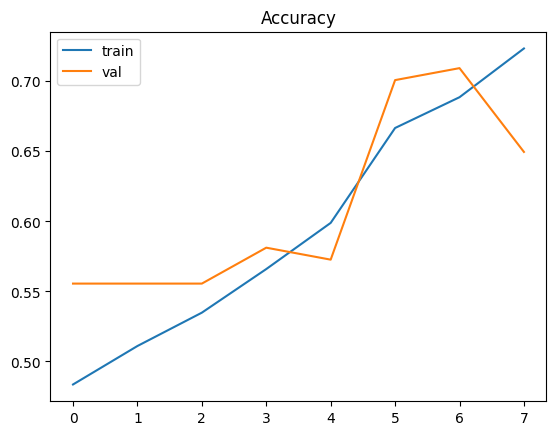

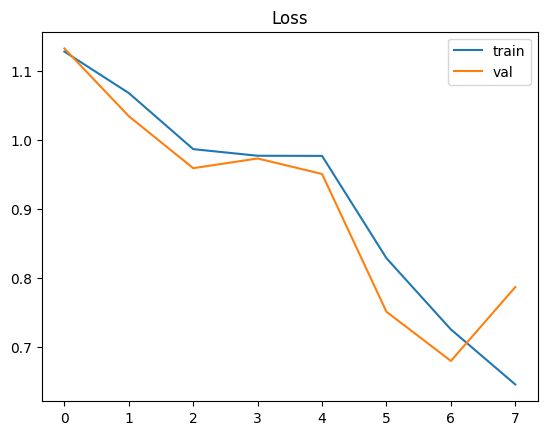

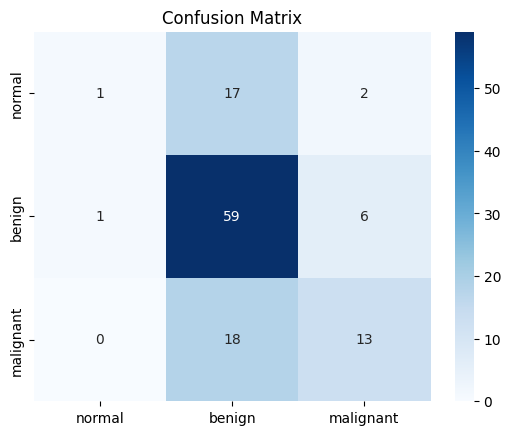

In [15]:

plt.figure(); plt.plot(history['train_acc'],label="train"); plt.plot(history['val_acc'],label="val"); plt.legend(); plt.title("Accuracy"); plt.show()
plt.figure(); plt.plot(history['train_loss'],label="train"); plt.plot(history['val_loss'],label="val"); plt.legend(); plt.title("Loss"); plt.show()

import seaborn as sns
cm = confusion_matrix(targets,preds)
sns.heatmap(cm,annot=True,fmt="d",cmap="Blues",xticklabels=tumor_types,yticklabels=tumor_types)
plt.title("Confusion Matrix"); plt.show()